In [45]:
import os

import scanpy as sc

from scgen_code.scgen._scgen import SCGEN


train = sc.read(os.path.join('..', 'data','train_kang.h5ad'),
                backup_url='https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk')
train_new = train[~((train.obs["cell_type"] == "CD4T") &
                    (train.obs["condition"] == "stimulated"))]
train_withheld = train[((train.obs["cell_type"] == "CD4T") &
                        (train.obs["condition"] == "stimulated"))]
train_new = train_new.copy()


model = SCGEN.load(os.path.join('saved_models', 'model_perturbation_prediction_trained.pt'), adata=train_new)
model

INFO     File saved_models\model_perturbation_prediction_trained.pt\model.pt already downloaded                    


c:\Users\PavloBilinskyi\OneDrive - Ladoburn Europe Ltd\Documents\Documents (onedrive)\Education\master\Spring\Курсова\venv\lib\site-packages\anndata\compat\__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
c:\Users\PavloBilinskyi\OneDrive - Ladoburn Europe Ltd\Documents\Documents (onedrive)\Education\master\Spring\Курсова\venv\lib\site-packages\anndata\compat\__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


SCGEN Model with the following params: 
n_hidden: 800, n_latent: 100, n_layers: 2, dropout_rate: 0.2
Training status: Trained

На даний момент передбачення збурень відбувається так:

In [40]:
import numpy as np
import torch
from anndata import AnnData


def get_latent_representation(adata):
    return model.get_latent_representation(adata)


def avg_vector(adata):
    return np.mean(get_latent_representation(adata), axis=0)

def from_latent_to_cells(adata):
    return model.module.generative(torch.Tensor(adata))["px"].cpu().detach().numpy()


def predict(train_adata, adata_to_predict):
    ctrl_x = train_adata[train_adata.obs['condition'] == 'control', :]
    stim_x = train_adata[train_adata.obs['condition'] == 'stimulated', :]

    # We won't balance the classes:
    # ctrl_x = balancer(ctrl_x, cell_type_key)
    # stim_x = balancer(stim_x, cell_type_key)


    # DELTA computation
    ## 1. Balance control and stimulated samples (undersampling) 
    eq = min(ctrl_x.X.shape[0], stim_x.X.shape[0])
    cd_ind = np.random.choice(range(ctrl_x.shape[0]), size=eq, replace=False)
    stim_ind = np.random.choice(range(stim_x.shape[0]), size=eq, replace=False)
    ctrl_adata = ctrl_x[cd_ind, :]
    stim_adata = stim_x[stim_ind, :]
    ## 2. Get latent representation of cells in train 
    #     dataset and compute averages for each group (control and stimulated)
    latent_ctrl_mean = np.mean(get_latent_representation(ctrl_adata), axis=0)
    latent_stim_mean = np.mean(get_latent_representation(stim_adata), axis=0)
    ## 3. Compute delta as difference between averages of the 
    delta = latent_stim_mean - latent_ctrl_mean
    
    ctrl_pred = adata_to_predict
    latent_cd = get_latent_representation(ctrl_pred)

    latent_stim_pred = delta + latent_cd

    # convert to AnnData
    predicted_cells = from_latent_to_cells(latent_stim_pred)
    predicted_adata = AnnData(
            X=predicted_cells,
            obs=ctrl_pred.obs.copy(),
            var=ctrl_pred.var.copy(),
            obsm=ctrl_pred.obsm.copy(),
        )
    predicted_adata.obs['condition'] = 'predicted stimulated'
    return latent_stim_pred, predicted_adata, delta, latent_ctrl_mean, latent_stim_mean


adata_cd4t_control = train[(train.obs['cell_type'] == 'CD4T') & (train.obs['condition'] == 'control')]
latent_stim_pred, adata_stim_pred, delta, latent_ctrl_mean, latent_stim_mean = predict(
                                                    train_adata=train_new, 
                                                    adata_to_predict=adata_cd4t_control)
latent_centroids = np.vstack([latent_ctrl_mean, latent_stim_mean])


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


### Visualize in latent space

         Falling back to preprocessing with `sc.pp.pca` and default params.


c:\Users\PavloBilinskyi\OneDrive - Ladoburn Europe Ltd\Documents\Documents (onedrive)\Education\master\Spring\Курсова\venv\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


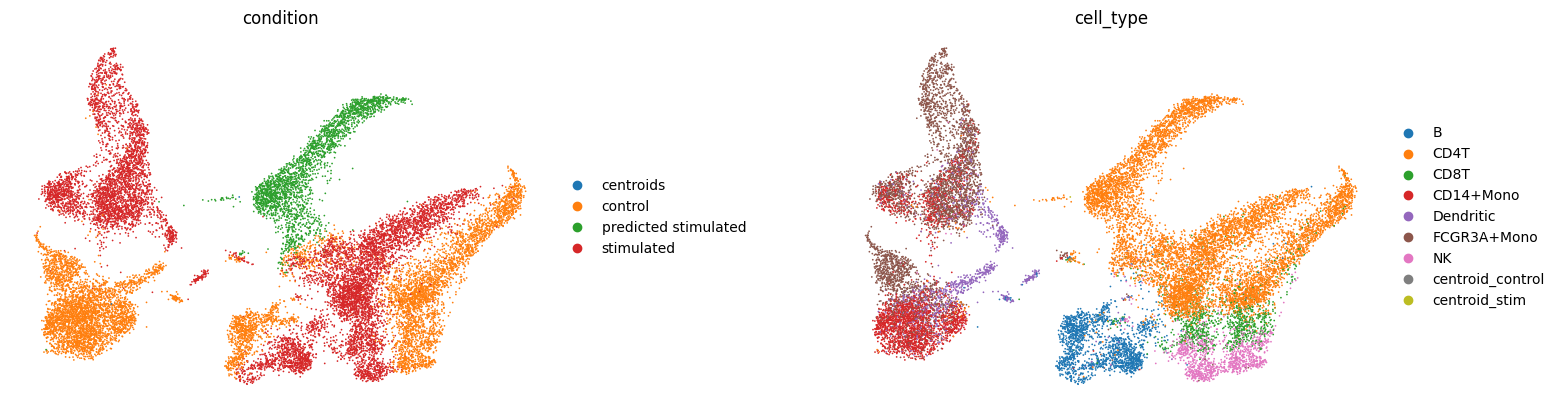

In [49]:
from anndata import AnnData


# Start with train data
latent_train_X = model.get_latent_representation()
latent_adata = sc.AnnData(X=latent_train_X,
                          obs=train_new.obs.copy()
                          )

# Add validation data (true responses)
latent_stim_eval = get_latent_representation(train_withheld)
latent_adata_eval = sc.AnnData(X=latent_stim_eval,
                              obs=train_withheld.obs.copy()
                          )
# Add predicted responses for validation data
latent_adata_pred = sc.AnnData(X=latent_stim_pred,
                          obs=adata_cd4t_control.obs.copy()
                          )
latent_adata_pred.obs['condition'] = 'predicted stimulated'

# Add centroids - means of control and stimulated groups in training
latent_adata_centroids = AnnData(
            X=latent_centroids,
            obs=train.obs.copy().iloc[:2]
            # obsm=ctrl_pred.obsm.copy(),
        )

latent_adata_centroids.obs['condition'] = 'centroids'
latent_adata_centroids.obs.index = ['centroid_control', 'centroid_stim']
latent_adata_centroids.obs['cell_type'] = ['centroid_control', 'centroid_stim']
latent_adata_centroids.obs[['n_counts', 'n_genes', 'mt_frac']] = 0

latent_adata = latent_adata.concatenate([latent_adata_pred, latent_adata_eval, latent_adata_centroids])

sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.pl.umap(latent_adata, color=['condition', 'cell_type'], wspace=0.4, frameon=False,
           save='latentspace_batch32_klw000005_z100__100e.pdf')

#### Convert back to the original space, to AnnData